In [29]:
from mplsoccer.pitch import Pitch, add_image
import pandas as pd
import numpy as np
import matplotlib.patheffects as path_effects
import time
from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt

In [19]:
url = ('https://fbref.com/en/share/pHebl')
df = pd.read_html(url)[0]
df = df[['Unnamed: 0_level_0','Pressures']].copy()
df.columns = df.columns.droplevel()

In [20]:
df.head()

,Squad,Press,Succ,%,Def 3rd,Mid 3rd,Att 3rd
0,Alavés,5609,1464,26.1,1757,2820,1032
1,Athletic Club,5447,1548,28.4,1709,2485,1253
2,Atlético Madrid,5111,1532,30.0,1616,2385,1110
3,Barcelona,4843,1488,30.7,1268,2305,1270
4,Betis,4922,1306,26.5,1589,2220,1113


In [21]:
pressure_cols = ['Def 3rd', 'Mid 3rd', 'Att 3rd']
df_total = pd.DataFrame(df[pressure_cols].sum())
df_total.columns = ['total']
df_total = df_total.T
df_total = df_total.divide(df_total.sum(axis=1), axis=0) * 100

In [22]:
df[pressure_cols] = df[pressure_cols].divide(df[pressure_cols].sum(axis=1), axis=0) * 100.
#df.sort_values(['Att 3rd', 'Def 3rd'], ascending=[True, False], inplace=True)

In [23]:
df

,Squad,Press,Succ,%,Def 3rd,Mid 3rd,Att 3rd
0,Alavés,5609,1464,26.1,31.324657,50.276342,18.399002
1,Athletic Club,5447,1548,28.4,31.375069,45.621443,23.003488
2,Atlético Madrid,5111,1532,30.0,31.618079,46.664058,21.717863
3,Barcelona,4843,1488,30.7,26.182119,47.594466,26.223415
4,Betis,4922,1306,26.5,32.283625,45.103616,22.612759
5,Celta Vigo,5389,1542,28.6,37.817777,42.976433,19.205790
6,Eibar,5515,1618,29.3,25.131460,46.636446,28.232094
7,Espanyol,5904,1660,28.1,32.588076,48.187669,19.224255
8,Getafe,6265,1868,29.8,26.081405,50.710295,23.208300
9,Granada,5814,1578,27.1,29.807362,49.604403,20.588235


In [24]:
pitch = Pitch(line_zorder=2, line_color='black', figsize=(16, 9), layout=(4, 5),
              tight_layout=False, constrained_layout=True)

In [25]:
bin_statistic = pitch.bin_statistic([0], [0], statistic='count', bins=(3, 1))

In [26]:
sb_logo = Image.open(urlopen(('https://github.com/statsbomb/open-data/blob/fb54bd7fe20dbd5299fafc64f1f6f0d919a5e40d/'
                              'stats-bomb-logo.png?raw=true')))

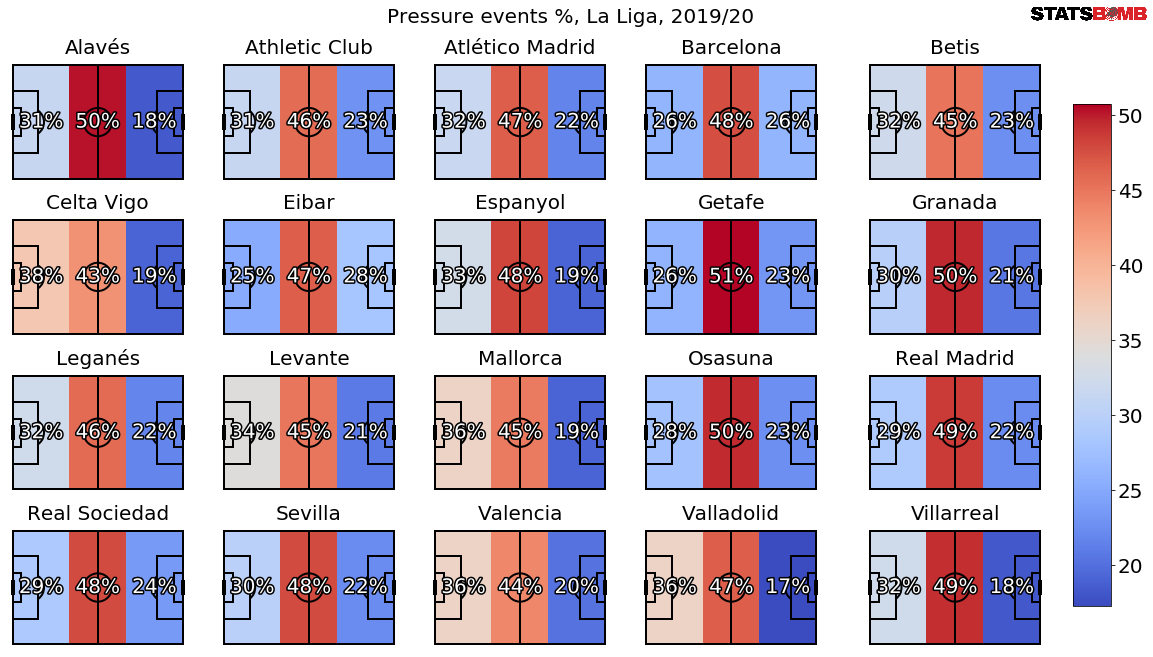

In [31]:
fig, axes = pitch.draw()
axes = axes.ravel()
teams = df['Squad'].values
vmin = df[pressure_cols].min().min()  # we normalise the heatmaps with the min / max values
vmax = df[pressure_cols].max().max()
for i, ax in enumerate(axes[:len(teams)]):
    ax.set_title(teams[i], fontsize=20)
    # fill in the bin statistics from df
    bin_statistic['statistic'] = df.loc[df.Squad == teams[i], pressure_cols].values
    heatmap = pitch.heatmap(bin_statistic, ax=ax, cmap='coolwarm', vmin=vmin, vmax=vmax)  # plot the heatmap
    # format and plot labels
    bin_statistic['statistic'] = (pd.DataFrame(bin_statistic['statistic'])
                                  .round(0).astype(np.int32).applymap(lambda x: '{:d}%'.format(x)).values)
    annotate = pitch.label_heatmap(bin_statistic, color='white', fontsize=20, ax=ax, ha='center', va='center')
    # set a black path effect around the labels
    for label in annotate:
        label.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
axes = axes.reshape(4, 5)
cbar = fig.colorbar(heatmap, ax=axes[:, 4], shrink=0.85)
cbar.ax.tick_params(labelsize=20)
# if its the Bundesliga remove the two spare pitches
if len(teams) == 18:
    for ax in axes[-1, 3:]:
        ax.remove()
add_image(sb_logo, fig, left=0.9, bottom=0.975, width=0.1)
title = fig.suptitle('Pressure events %, La Liga, 2019/20', fontsize=20)
plt.savefig('pressures.png')